In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pickle as pkl 
from pathlib import Path

In [2]:
df = pd.read_csv('Network_anomaly_data.csv')
df.head().T

,0,1,2,3,4
duration,0,0,0,0,0
protocoltype,tcp,udp,tcp,tcp,tcp
service,ftp_data,other,private,http,http
flag,SF,SF,S0,SF,SF
srcbytes,491,146,0,232,199
dstbytes,0,0,0,8153,420
land,0,0,0,0,0
wrongfragment,0,0,0,0,0
urgent,0,0,0,0,0
hot,0,0,0,0,0


In [3]:
attack_percentage = df['attack'].value_counts(normalize=True)
attack_percentage.to_frame().T

attack,normal,neptune,satan,ipsweep,portsweep,smurf,nmap,back,teardrop,warezclient,...,warezmaster,land,imap,rootkit,loadmodule,ftp_write,multihop,phf,perl,spy
proportion,0.534583,0.327165,0.02884,0.02857,0.023267,0.021005,0.011852,0.007589,0.007081,0.007065,...,0.000159,0.000143,0.000087,0.000079,0.000071,0.000064,0.000056,0.000032,0.000024,0.000016


In [4]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   duration                125973 non-null  int64  
 1   protocoltype            125973 non-null  object 
 2   service                 125973 non-null  object 
 3   flag                    125973 non-null  object 
 4   srcbytes                125973 non-null  int64  
 5   dstbytes                125973 non-null  int64  
 6   land                    125973 non-null  int64  
 7   wrongfragment           125973 non-null  int64  
 8   urgent                  125973 non-null  int64  
 9   hot                     125973 non-null  int64  
 10  numfailedlogins         125973 non-null  int64  
 11  loggedin                125973 non-null  int64  
 12  numcompromised          125973 non-null  int64  
 13  rootshell               125973 non-null  int64  
 14  suattempted         

(None, (125973, 43))

### There are no missing values.

In [5]:
print(f'Total missing values {df.isna().sum().sum()}')

Total missing values 0


## EDA

In [6]:
categorical, numerical = [], []
for cols in df.columns:
    if df[cols].dtype == 'object':
        categorical.append(cols)
    else:
        numerical.append(cols)

print(f'Categorical Columns: \n{categorical}')
print(f'Numerical Columns: \n{numerical}')

Categorical Columns: 
['protocoltype', 'service', 'flag', 'attack']
Numerical Columns: 
['duration', 'srcbytes', 'dstbytes', 'land', 'wrongfragment', 'urgent', 'hot', 'numfailedlogins', 'loggedin', 'numcompromised', 'rootshell', 'suattempted', 'numroot', 'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds', 'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'serrorrate', 'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate', 'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate', 'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate', 'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'lastflag']


In [7]:
print('Number of unique values per categorical column.')
for cols in categorical: 
    print(f'{cols} - {df[cols].nunique()}')

Number of unique values per categorical column.
protocoltype - 3
service - 70
flag - 11
attack - 23


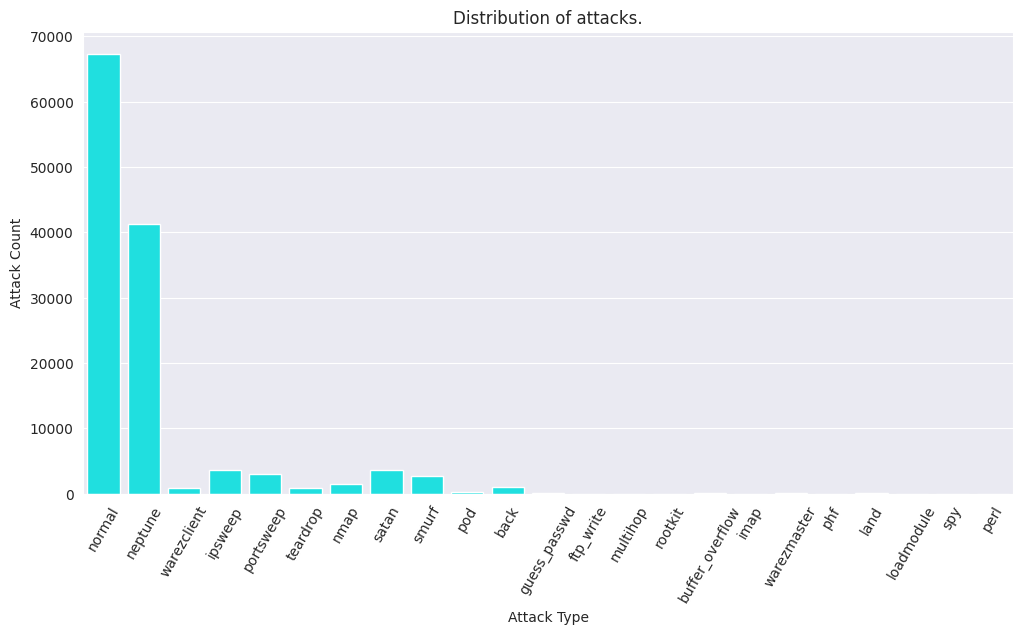

In [9]:
plt.figure(figsize=(12, 6))


sns.countplot(data = df, x = 'attack', color = 'cyan')
plt.title('Distribution of attacks.')
plt.xlabel('Attack Type')
plt.ylabel('Attack Count')
plt.xticks(rotation=60)
plt.show()

In [10]:
labels = df['attack'].value_counts()
filtered_labels = labels[labels > 1000].index.to_list()
print(filtered_labels)

['normal', 'neptune', 'satan', 'ipsweep', 'portsweep', 'smurf', 'nmap']


In [11]:
# REMOVE SMALL ATTACKS
df = df[df['attack'].isin(filtered_labels)]
df = df.reset_index()

In [12]:
df.drop(columns=['index'], inplace=True)

In [13]:
'''
I was thinking of using label encoding for all categorical columns.
Label encoding assumes inhernt order, which is not true. So I will use
frequency/count encoding. Using OHE is a bad idea because of curse of 
dimensionality.
'''
df_1 = df.copy()
mega_mapping = {}
for col in categorical:
    mapping = df[col].value_counts().to_dict()
    # Use integers instead of frequency. 
    mapping_list = [(v, k) for k, v in mapping.items()]
    mapping_list.sort()
    mapping = {k: i for i, (v, k) in enumerate(mapping_list)}
    mega_mapping[col] = mapping
    # Begin mapping. 
    df_1[col] = df_1[col].map(mapping)
df_1[categorical].head().T

,0,1,2,3,4
protocoltype,2,1,2,2,2
service,65,63,68,69,69
flag,10,10,9,10,10
attack,6,6,5,6,6


### PCA plot.

/home/tirthankar-mittra/ai_ml/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


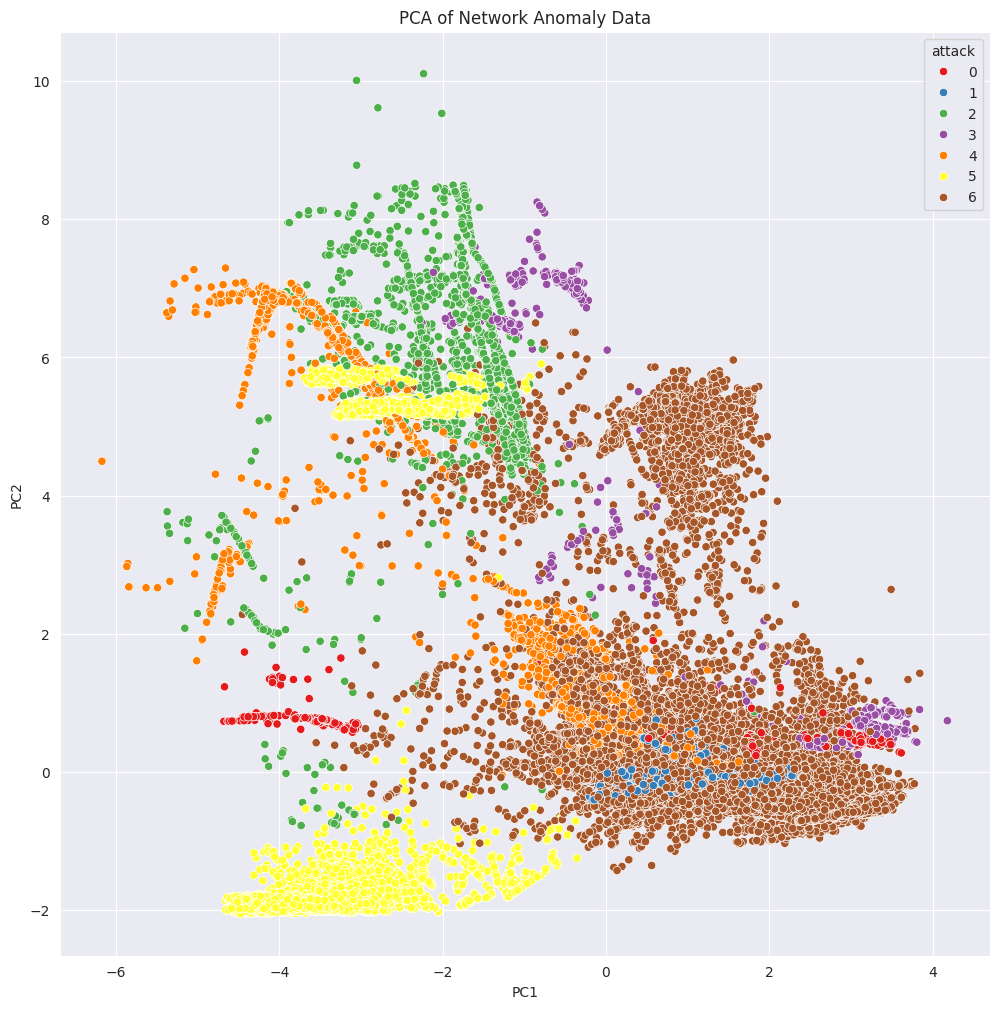

In [14]:
df_2 = df_1.copy()
X, Y = df_2.drop(columns=['attack']), df_2['attack']
df_2.drop(columns=['attack'], inplace=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = df_2.columns)
pca = PCA(n_components=2)
X_redx = pca.fit_transform(X)
X_redx = pd.DataFrame({
    'PC1': X_redx[:, 0],
    'PC2': X_redx[:, 1],
    'attack': Y
})

plt.figure(figsize=(12, 12))
sns.scatterplot(data=X_redx, x='PC1', y='PC2', hue='attack', palette='Set1')
plt.title('PCA of Network Anomaly Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### TSNE plot.

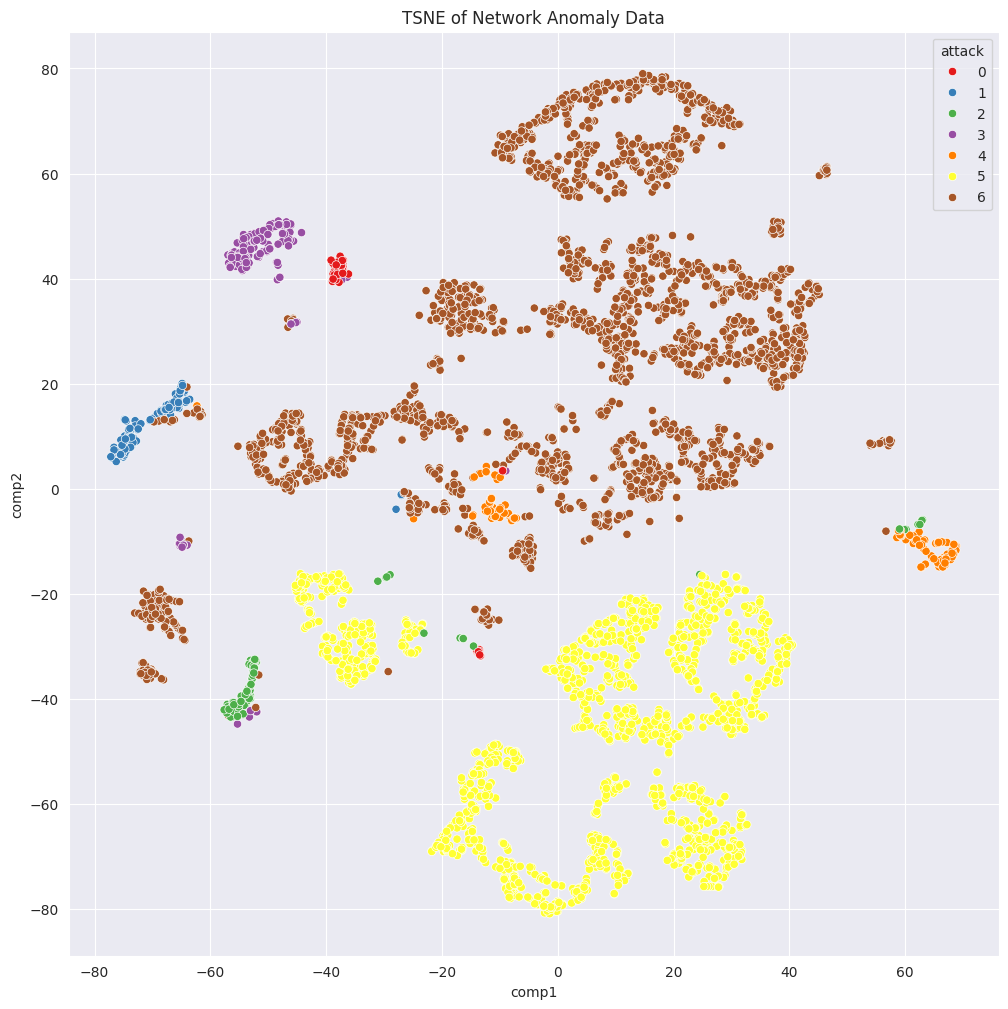

In [17]:
X_tsne = X.sample(5000)

tsne = TSNE(n_components=2, random_state=42)
X_tsne_redx = tsne.fit_transform(X_tsne)
X_tsne_redx = pd.DataFrame({
    'comp1': X_tsne_redx[:, 0],
    'comp2': X_tsne_redx[:, 1],
    'attack': Y[X_tsne.index]
})

plt.figure(figsize=(12, 12))
sns.scatterplot(data=X_tsne_redx, x='comp1', y='comp2', hue='attack', palette='Set1')
plt.title('TSNE of Network Anomaly Data')
plt.xlabel('comp1')
plt.ylabel('comp2')
plt.show()

### Hypothesis Testing [TBD].

### Checkpoint 1.

In [15]:
## For non tree based methods. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=2025)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=0.2,
                                          random_state=2025)
dataset = {
    'X_tr': X_tr,
    'Y_tr': Y_tr,
    'X_cv': X_cv,
    'Y_cv': Y_cv,
    'X_test': X_test,
    'Y_test': Y_test
}

## For tree based methods. 
dataset_tree = {
    'X_tr': df.loc[X_tr.index], 
    'Y_tr': Y_tr,
    'X_cv': df.loc[X_cv.index],
    'Y_cv': Y_cv,
    'X_test': df.loc[X_test.index],
    'Y_test': Y_test
}
dataset_tree['X_tr'].drop(columns=['attack'], inplace=True)
dataset_tree['X_cv'].drop(columns=['attack'], inplace=True)
dataset_tree['X_test'].drop(columns=['attack'], inplace=True)


DATA = Path().cwd() / "data_and_models"
with open(f"{DATA}/dataset.pkl", 'wb') as f: 
    pkl.dump(dataset, f)

with open(f"{DATA}/dataset_tree.pkl", 'wb') as f:
    pkl.dump(dataset_tree, f)

with open(f"{DATA}/mapping.pkl", 'wb') as f:
    pkl.dump(mega_mapping, f)

In [16]:
with open(f"{DATA}/scaler.pkl", 'wb') as f:
    pkl.dump(scaler, f)

default_values = {
    col: df_1[col].median() for col in df_1.columns
}
with open(f"{DATA}/default_values.pkl", 'wb') as f:
    pkl.dump(default_values, f)

In [9]:
values = "0	tcp	private	S0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	123	6	1	1	0	0	0.05	0.07	0	255	26	0.1	0.05	0	0	1	1	0	0	neptune	19"

input = {}
for idx, value in enumerate(values.split("\t")):
    col_name = df.columns[idx]
    if col_name in categorical:
        input[col_name] = value 
    else: input[col_name] = float(value)

input

{'duration': 0.0,
 'protocoltype': 'tcp',
 'service': 'private',
 'flag': 'S0',
 'srcbytes': 0.0,
 'dstbytes': 0.0,
 'land': 0.0,
 'wrongfragment': 0.0,
 'urgent': 0.0,
 'hot': 0.0,
 'numfailedlogins': 0.0,
 'loggedin': 0.0,
 'numcompromised': 0.0,
 'rootshell': 0.0,
 'suattempted': 0.0,
 'numroot': 0.0,
 'numfilecreations': 0.0,
 'numshells': 0.0,
 'numaccessfiles': 0.0,
 'numoutboundcmds': 0.0,
 'ishostlogin': 0.0,
 'isguestlogin': 0.0,
 'count': 123.0,
 'srvcount': 6.0,
 'serrorrate': 1.0,
 'srvserrorrate': 1.0,
 'rerrorrate': 0.0,
 'srvrerrorrate': 0.0,
 'samesrvrate': 0.05,
 'diffsrvrate': 0.07,
 'srvdiffhostrate': 0.0,
 'dsthostcount': 255.0,
 'dsthostsrvcount': 26.0,
 'dsthostsamesrvrate': 0.1,
 'dsthostdiffsrvrate': 0.05,
 'dsthostsamesrcportrate': 0.0,
 'dsthostsrvdiffhostrate': 0.0,
 'dsthostserrorrate': 1.0,
 'dsthostsrvserrorrate': 1.0,
 'dsthostrerrorrate': 0.0,
 'dsthostsrvrerrorrate': 0.0,
 'attack': 'neptune',
 'lastflag': 19.0}